<a href="https://colab.research.google.com/github/arya1406/airline-twitter-statement-classification/blob/master/Copy_of_BPML2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# untuk menginstall library loss plot 
!pip install livelossplot

In [5]:
# import library yang dibutuhkan

import pandas as pd        # manipulasi dan analisis data
from nltk.corpus import stopwords
import seaborn as sns
from nltk.stem.porter import PorterStemmer
import re
import nltk
nltk.download('stopwords')
import numpy as np
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# inisialisasi dataset

df = pd.read_csv('Tweets.csv')

df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [7]:
# men-drop kolom yang tidak digunakan

df = df.drop(columns=['tweet_id',
                      'airline_sentiment_confidence',
                      'negativereason',
                      'negativereason_confidence',
                      'airline_sentiment_gold',
                      'negativereason_gold',
                      'retweet_count',
                      'tweet_coord',
                      'tweet_created',
                      'tweet_location',
                      'user_timezone',
                      'name',
                      'airline'])
df

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


In [8]:
# menghitung tiap kelas
count_neg, count_neu, count_pos = df.airline_sentiment.value_counts()

#  kelas menjadi dataframe baru
df_class_neg = df[df['airline_sentiment'] == 'negative']
df_class_neu = df[df['airline_sentiment'] == 'neutral']
df_class_pos = df[df['airline_sentiment'] == 'positive']

print ("jumlah negatif statement = {}".format(count_neg))
print ("jumlah netral statement = {}".format(count_neu))
print ("jumlah positif statement = {}".format(count_pos))

jumlah negatif statement = 9178
jumlah netral statement = 3099
jumlah positif statement = 2363


Random over-sampling:
neutral     9178
positive    9178
negative    9178
Name: airline_sentiment, dtype: int64


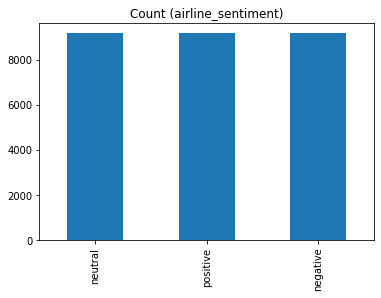

In [9]:
# dikarenakan sample tidak seimbang, maka dilakukan pemerataan dengan resample

df_class_pos_over = df_class_pos.sample(count_neg, replace=True)
df_class_neu_over = df_class_neu.sample(count_neg, replace=True)
df_test_over = pd.concat([df_class_neg, df_class_pos_over, df_class_neu_over], axis=0)

print('Random over-sampling:')
print(df_test_over.airline_sentiment.value_counts())

df_test_over.airline_sentiment.value_counts().plot(kind='bar', title='Count (airline_sentiment)');

In [10]:
# one hot encode (untuk mengubah label statement menjadi angka)

category = pd.get_dummies(df_test_over.airline_sentiment)
df_fix = pd.concat([df_test_over, category], axis=1)
df_fix = df_fix.drop(columns='airline_sentiment')
df_fix

,text,negative,neutral,positive
3,@VirginAmerica it's really aggressive to blast...,1,0,0
4,@VirginAmerica and it's a really big bad thing...,1,0,0
5,@VirginAmerica seriously would pay $30 a fligh...,1,0,0
15,@VirginAmerica SFO-PDX schedule is still MIA.,1,0,0
17,@VirginAmerica I flew from NYC to SFO last we...,1,0,0
...,...,...,...,...
11643,@USAirways I just hope that pilot had a good d...,0,1,0
9765,@USAirways what happens to frequent flyer mile...,0,1,0
6639,@SouthwestAir followed.,0,1,0
473,@VirginAmerica you got cheese pLate Flights too.,0,1,0


In [11]:
# fungsi untuk membersihkan text
def clean_text(text):
    # menghapus backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # menghapus semua karakter kecuali alfabet 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # menghapus whitespaces 
    text = ' '.join(text.split()) 
    
    return text

In [12]:
# mengaplikasikan pada dataset
df_fix['text'] = df_fix['text'].apply(lambda x: clean_text(x))

df_fix


,text,negative,neutral,positive
3,VirginAmerica its really aggressive to blast o...,1,0,0
4,VirginAmerica and its a really big bad thing a...,1,0,0
5,VirginAmerica seriously would pay a flight for...,1,0,0
15,VirginAmerica SFO PDX schedule is still MIA,1,0,0
17,VirginAmerica I flew from NYC to SFO last week...,1,0,0
...,...,...,...,...
11643,USAirways I just hope that pilot had a good da...,0,1,0
9765,USAirways what happens to frequent flyer miles...,0,1,0
6639,SouthwestAir followed,0,1,0
473,VirginAmerica you got cheese pLate Flights too,0,1,0


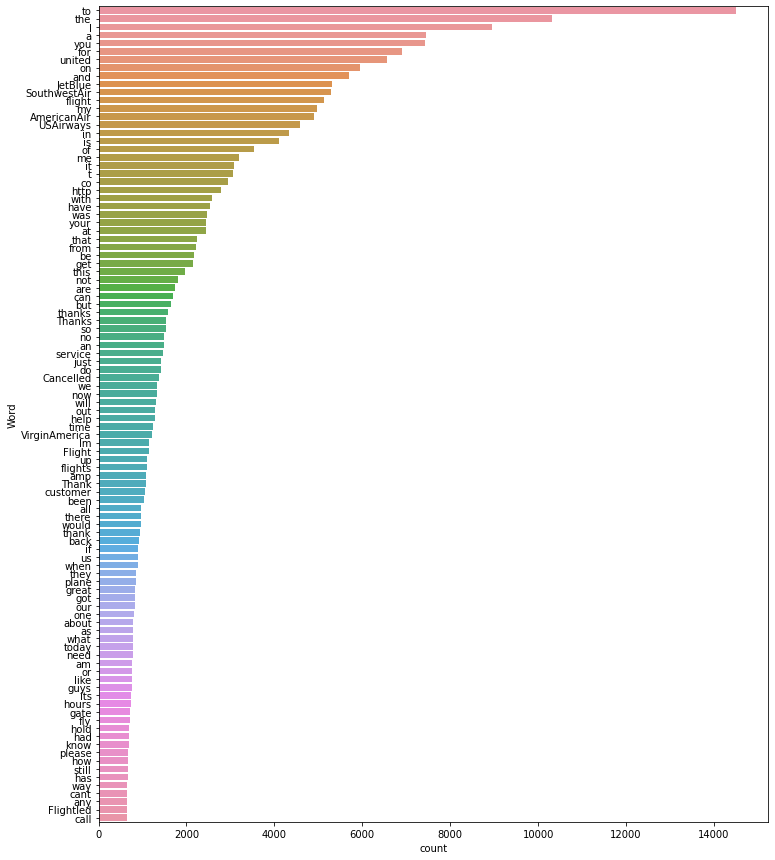

In [13]:
# fungsi untuk menghitung jumlah kata terbanyak di dalam dataset

def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  #  top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(df_fix['text'], 100)

In [14]:
# menghapus stopword pada dataset

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

df_fix['text'] = df_fix['text'].apply(lambda x: remove_stopwords(x))


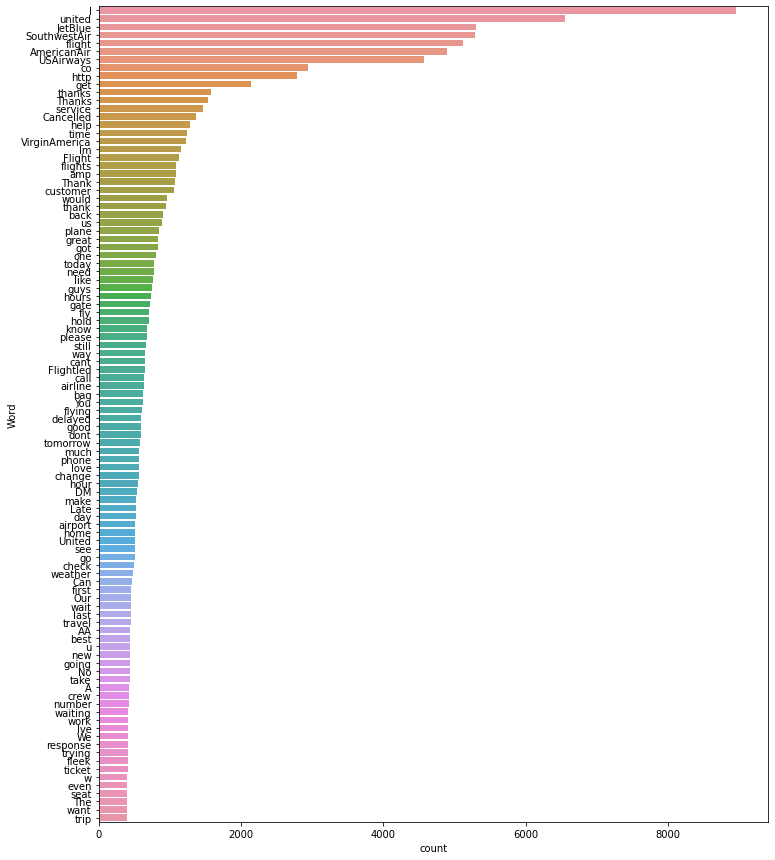

In [15]:
freq_words(df_fix['text'], 100)

In [16]:
# inisiasi variabel

text = df_fix['text'].values
label_sentiment = df_fix[['negative', 
                      'neutral',
                      'positive']].values

In [17]:
# split data train dan data test

from sklearn.model_selection import train_test_split
plot_train, plot_test, label_genre_train, label_genre_test = train_test_split(text, label_sentiment, test_size=0.2)

In [18]:
# Tokenisasi (mengkonversi kata menjadi bilangan numerik)
# A = 'ayah lupa bawa palu'          -> [1, 108, 77, 35]
# B = 'Ibu lupa membeli palu ditoko' -> [2, 108, 71, 35, 11, 125]
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=4000, oov_token='x')
tokenizer.fit_on_texts(plot_train) 
tokenizer.fit_on_texts(plot_test)
 
sequences_train = tokenizer.texts_to_sequences(plot_train)
sequences_test = tokenizer.texts_to_sequences(plot_test)

#Proses padding (mengubah setiap sequence agar mempunyai panjang yg sama)
# A = [1, 108, 77, 35]          -> [1, 108, 77, 35, 0, 0]
# B = [2, 108, 71, 35, 11, 125] -> [2, 108, 71, 35, 11, 125]
padded_train = pad_sequences(sequences_train) 
padded_test = pad_sequences(sequences_test)

In [19]:
# membuat model 

import keras
from keras.regularizers import l1,l2
from tensorflow.keras import regularizers
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=4000, output_dim=128),
    tf.keras.layers.LSTM(256),  #layer yg dapat memahami makna sebuah kalimat dari kalimat sebelumnya
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # untuk mencegah overfitting
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         512000    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3

In [22]:
# membuat callback (mendapatkan data saat berjalannya training data)

import livelossplot

# inisiasi plot loss
plot_losses = livelossplot.PlotLossesKeras()

# ketika val_acc > 91%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.90):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks_end = myCallback()

# learning rate scheduler
def scheduler(epoch, lr):
  if epoch < 1:
    return lr
  else:
    return lr * tf.math.exp(-0.9)
callbacks_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

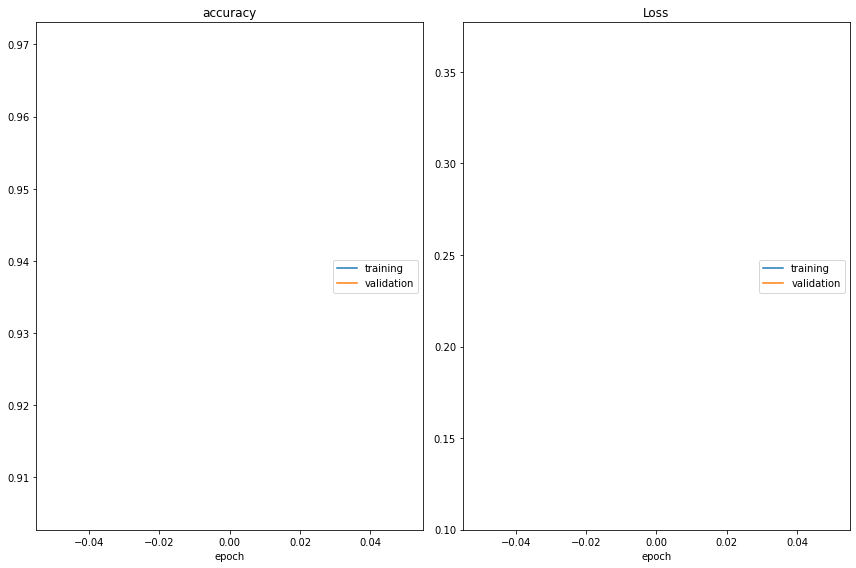

accuracy
	training         	 (min:    0.970, max:    0.970, cur:    0.970)
	validation       	 (min:    0.906, max:    0.906, cur:    0.906)
Loss
	training         	 (min:    0.112, max:    0.112, cur:    0.112)
	validation       	 (min:    0.364, max:    0.364, cur:    0.364)

Akurasi telah mencapai >90%!


In [23]:
# latih model

history = model.fit(padded_train,
                    label_genre_train,
                    epochs=30,
                    verbose=1,
                    callbacks=[plot_losses, callbacks_end, callbacks_lr],
                    validation_data=(padded_test, label_genre_test))

In [21]:

yhat = model.predict(X, verbose=1)